# NYPD Civilian Complaints
## Assessment of Missingness and Hypothesis Test

# Summary of Findings

### Introduction
The dataset that we are looking at contains information about complaints made against the NYPD's MOS (Member of Service) and their case results. The dataset has 33,358 individual civilian complaints made in New York City. The dates of these complaints range from September 1985 to January 2020. The data set can generate insights on police misconduct on the different minority communities in New York.

### Cleaning and EDA
With regards to the data cleaning process, we checked for any values in the columns that could indicate a missing value (i.e. a “-”, empty string, or keywords such as “refused” or “not described”) and used some primary research to filter out what values were meant to be missing but not indicated as such. For example, the precincts of New York are numbered between 1 and 123. However, in the data there were precinct values that were 0 and 1000, which means these values were most likely meant to be missing. Additionally, we performed column operations that allowed us to reduce multiple columns into a single column to make analysis easier and make the data set more space efficient. For example, the month and year of the opening and closing of a case was combined into one column that was a time delta object that describes the amount of time it took for a case to be investigated.


### Assessment of Missingness
In our assessment of missingness, we wanted to determine whether columns were Missing by Design (MD), Not Missing at Random (NMAR), Missing at Random (MAR), or Missing Completely at Random (MCAR). Using the dataset and knowledge of the data-generating process, we found that the `shield_no` column is MD because its missingness can be determined by values in other columns. In the NYPD, any MOS with a rank of Lieutenant or higher is not given a shield number, so their shield number will be missing by design in the dataset. 

We then chose to analyze the `contact_reason` column, which contains the reason the MOS made contact with the complainant. Using domain knowledge, we determined that this column is not NMAR because the missingness does not depend on the values contained in the `contact_reason` column. Using the values contained in this column, it seems like they were generated while using a drop-down menu, so there was no systematic way for the value to be missing dependent on the value itself. We then performed permutation tests to analyze the dependency of `contact_reason` on `complainant_ethnicity` and `precinct`. At a significance level of 0.05, there was insufficient evidence to support the claim that `contact_reason` is MAR dependent on `complainant_ethnicity`. On the other hand, there was sufficient evidence to support the claim that `contact_reason` is MAR dependent on `precinct`. The p-values of these tests were 0.241 and 0.0, respectively. This could suggest that certain precincts tend to mishandle data, leading to missing values in the contact_reason column.

Although we rejected the null hypothesis that there is no dependence between `contact_reason` and `precinct`, we are highly skeptical of the results because only around 0.5% of the contact_reason column is null. These results are unreliable due to the large disparity between the sizes of the null and non-null contact reasons.
 
### Hypothesis Test
We formulated a permutation (A/B) test to answer the question: Do complaints made by Black individuals have a varying degree of success than complaints made by non-Black individuals? We found a permutation test to be most appropriate in answering this question because there are two distinct populations: Black and non-Black complainants. The null hypothesis was that the populations are from the same distribution, so they have the same degree of success. The alternative hypothesis was that the populations have varying degrees of success, and originate from different distributions. Since the columns we chose we categorical, we used the total variation distance (TVD) as our test statistic. We chose a significance level of 0.01.

We first cleaned the dataset and encoded the columns as Boolean arrays, depending on whether a complainant was Black or not and whether a case was successful or not. We considered all Substantiated cases to be successful for the complainant because according to the data-generating process, a Substantiated decision meant that the CCRB determined that the alleged conduct occured and was unlawful. Exonerated or Unsubstantiated cases would be unsuccessful because they either ruled in favor of the MOS or dismissed the validity of the complaint. After shuffling the columns, finding the conditional distributions, and TVD in 1000 simulated trials, we found a p-value of 0.001. This led us to reject the claim that the distribution of successful complaints for Black and non-Black individuals is the same. In other words, there was sufficient evidence to support the claim that the distribution of complaints originate from distinct distributions. This could mean that the success of a case may be impacted by, or associated with, whether or not the complainant was Black.

Once again, although the permutation test suggested to reject the null hypothesis, we were skeptical of the conclusion because the distributions were not even. More specifically, there were 25,057 unsuccessful claims and only 8,301 successful claims. There were 17,114 Black complainants and 10,480 non-Black complainants. This makes it difficult to generalize the results because the distributions are skewed towards Black complainants and unsuccessful claims.

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [2]:
complaints = pd.read_csv('data/allegations_202007271729.csv')
complaints.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,...,39,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A)


### Cleaning and EDA

#### Data Cleaning

In [3]:
# Creates a new column for the full name of the MOS because the individual first and last names are not meaningful for our analysis.
complaints = complaints.assign(mos_name = (complaints['first_name'] + ' ' + complaints['last_name'])).drop(columns = ['first_name', 'last_name'])

In [4]:
# Converting the individual months and years into datetime objects to easily find the Timedelta
date_received = pd.to_datetime(complaints['month_received'].astype(str) + '-' + complaints['year_received'].astype(str))
date_closed = pd.to_datetime(complaints['month_closed'].astype(str) + '-' + complaints['year_closed'].astype(str))

# Subtracting investigation close and open times to determine how long the case was reviewed by CCRB
investigation_time = date_closed - date_received

# Dropped the month_closed and year_closed columns because they aren't as meaningful as the month and year that the complaint was received
complaints = complaints.assign(investigation_time = investigation_time).drop(columns = ['month_closed', 'year_closed'])

In [5]:
# Creates a new column for determining whether the MOS's rank at the time of the incident matches their rank as of July 2020
rank_change = (complaints['rank_abbrev_now'] != complaints['rank_abbrev_incident'])
complaints = complaints.assign(rank_change = rank_change)

The following cell contains the process of replacing data that should be missing with `NaN`.
* First check the data type of the column of interest.
* If numerical (integer or floating-point values): check the minimum and maximum values of the column and determine whether they are reasonable according to the context.
* If string values: get the unique values, check if there is anything of length 0 or 1 to see if there are any dashes or empty strings that should be `NaN`. Also check whether there are any words such as `Refused` or `Unknown` that indicate a missing value.


The process for each column with regards to the data-generating process:

* Shield Number: We decided to replace any shield numbers of 0 with `NaN` because after [primary research](https://en.wikipedia.org/wiki/New_York_City_Police_Department), we learned that MOS ranked as Lieutenants or above do not have shield numbers. In the dataset, all these high-ranking members had shield numbers of 0. We decided to replace this with `NaN` because they do not have shield numbers, so they should be represented by missing values.
* Complainant Ethnicity: After doing a `value_counts()` call on the ethnicity column, we noticed that several individuals were marked as `Unknown` or `Refused`. This indicated that their ethnicity was not successfully recorded, so the values would be better suited to be `NaN`.
* Complainant Gender: After doing a `value_counts()` call on the gender column, we noticed that several individuals were marked as `Not described`. This indicated that their gender was not successfully recorded, so the values would be better suited to be `NaN`.
* Complainant Ages: We looked at the minimum value and saw that it had a value of -4301, which is highly unreasonable. There were also several ages with negative or 0 values. These were the first values we determined were missing. Next, we looked at the 5 highest ages in the dataset and noticed that there were 2 101-year old complainants. While this is possible, we looked into the data to determine if there was anything systematic about this age. We then learned that it was most likely the same complainant who made two reports because the date, precinct, MOS name, and complainant ethnicity were the same across both reports. The next highest age was 90, which is a feasible age. This led us to not turn any high values into `NaN`. Finally, we decided that ages less than or equal to 10 were not feasible and likely due to human error during input. We therefore decided to turn all values less than or equal to 10 into `NaN`.
* Precinct: After some [primary research](https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page), we learned that the NYPD precincts range from 1 to 123, with some values missing in between. In the dataset, we saw 21 precincts with a value of 0 and 3 precincts with a value of 1000. The rest of the values came from valid NYPD precinct numbers. Therefore, we manually replaced precinct numbers of 0 and 1000 to `NaN`.
* Ranks, Command Codes, and Allegation: We corroborated the ranks and codes with the CCRB Data Layout spreadsheet to see if anything seemed out of ordinary. We determined that many codes did not overlap between the `complaints` dataset and the spreadsheet, but decided not to replace any values with `NaN` because there was nothing systematic about these values.

In [6]:
complaints['shield_no'] = complaints['shield_no'].replace(0, np.NaN)
complaints['complainant_ethnicity'] = complaints['complainant_ethnicity'].replace({'Refused': np.NaN, 'Unknown': np.NaN})
complaints['complainant_gender'] = complaints['complainant_gender'].replace('Not described', np.NaN)
complaints['complainant_age_incident'] = complaints['complainant_age_incident'].apply(lambda x: np.NaN if x <= 10 else x)
complaints['precinct'] = complaints['precinct'].replace({0: np.NaN, 1000: np.NaN})

#### Univariate Analysis

In this figure, we decided to plot the univariate distributions of the MOS age and complainant age. After plotting the distributions on the same scale, we noticed that the mean, or balancing point, is around 30 years of age for both distributions. We noticed that both distributions have a right skew, which is due to the fact that children will not likely be a MOS or have run-in with a MOS. Moreover, we saw that the ages for MOS were confined between the ages of 20 and 60. This corroborates the fact that NYPD MOS must be at least 21 years of age, and most officers would retire by age 60. The distribution of complainants has a much higher upper limit because senior citizens can have run-ins with the MOS.

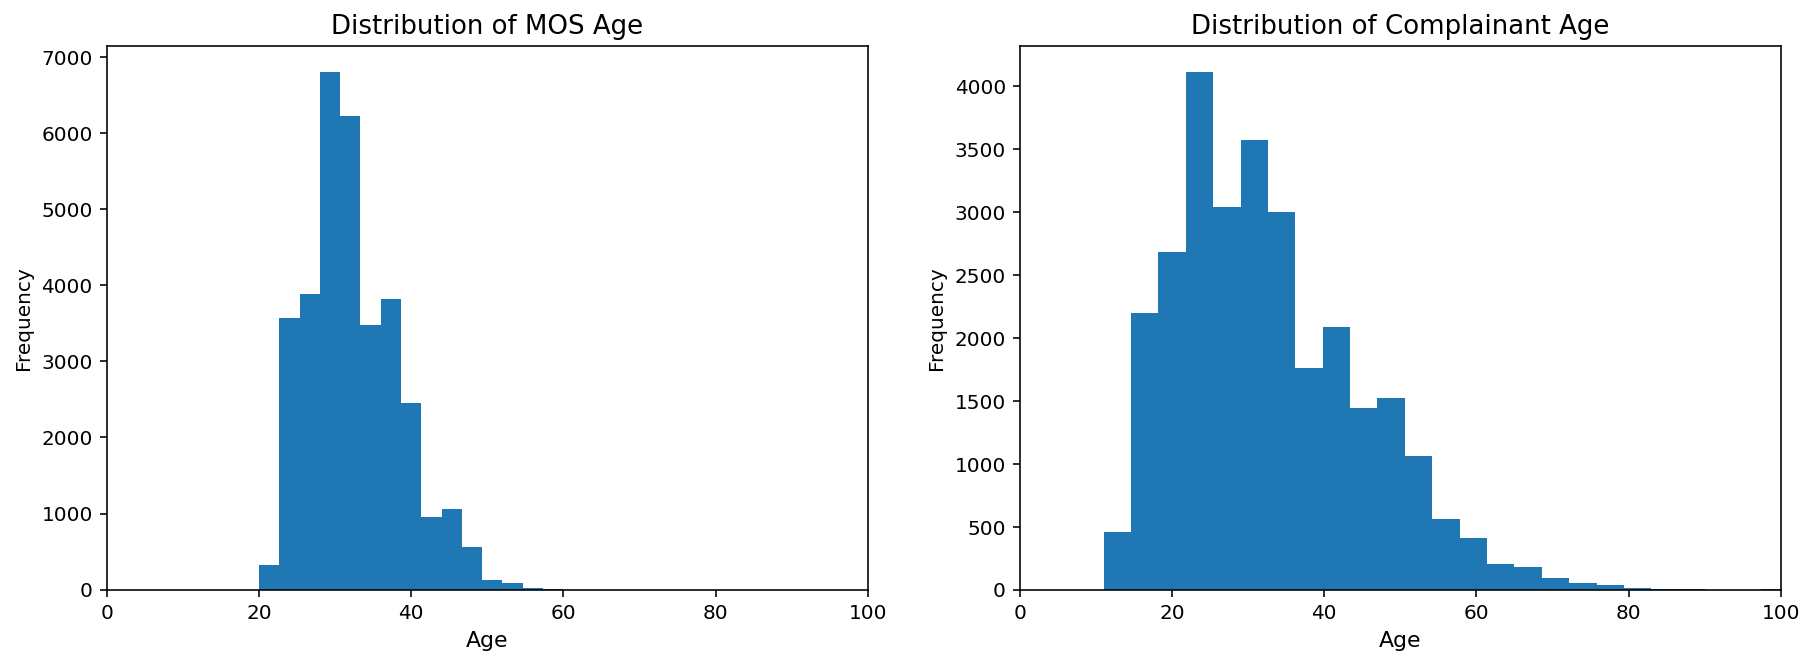

In [7]:
# Create a wide figure with 2 subplots for histograms
fig, axes = plt.subplots(1, 2, figsize = (15,5))

# Histogram for MOS age distribution with age on a scale up to 100
complaints['mos_age_incident'].plot(kind = 'hist', ax=axes[0], bins = 15, xlim = (0,100))
axes[0].set_title('Distribution of MOS Age', fontsize = 13);
axes[0].set_xlabel('Age', fontsize = 11);

# Histogram for Complainant age distribution with age on a scale up to 100
complaints['complainant_age_incident'].plot(kind = 'hist', ax=axes[1], bins = 25, xlim = (0,100))
axes[1].set_title('Distribution of Complainant Age', fontsize = 13);
axes[1].set_xlabel('Age', fontsize = 11);

In this plot, we wanted to determine the distribution of results for the complaints as a whole. We combined all the substantiated claims because they all have the result of a successful case. Although they have specific distinctions, the result is effectively the same: the case is validated and the MOS has a penalty. We noticed that majority of the cases were unsuccesful: exonerated or unsubstantiated.

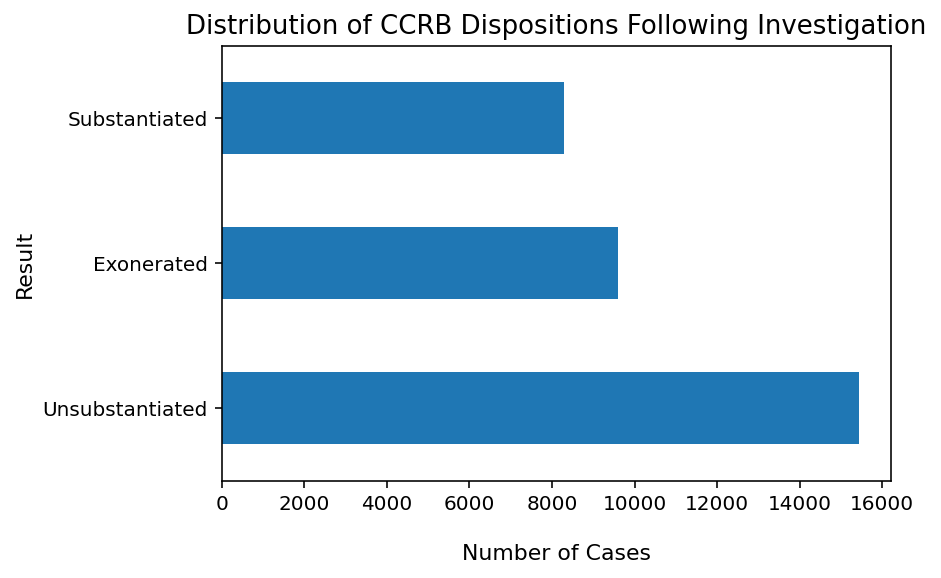

In [8]:
# Likening all cases that were substantiated into one category
broad_disposition = complaints['board_disposition'].apply(lambda x: 'Substantiated' if ('Substantiated' in x) else x)

# Plotting the frequency of each CCRB result
ax = broad_disposition.value_counts().plot(kind = 'barh')
ax.set_title('Distribution of CCRB Dispositions Following Investigation', fontsize = 13);
ax.set_xlabel('Number of Cases', fontsize = 11, labelpad = 15);
ax.set_ylabel(ylabel = 'Result', fontsize = 11);

We used the `.describe()` method on the ages of MOS and complainants to generate summary statistics. We noticed that they have a very similar mean and median ages, supporting our observation from the first plot. However, the complainant ages have a significantly larger spread, which is due to the MOS ages being more restrictive from 20 to 60. We also noted that there were as many MOS ages as the number of rows in the dataset, while there were 4843 missing complainant ages. 

In [9]:
# Generating summary statistics and casting to DataFrame
mos_age_stats = pd.DataFrame(complaints['mos_age_incident'].describe())
complainant_age_stats = complaints['complainant_age_incident'].describe()

# Horizontally concatenate the summary statistic DataFrames
age_stats = pd.concat([mos_age_stats, complainant_age_stats], axis = 1)
age_stats

,mos_age_incident,complainant_age_incident
count,33358.000000,28515.000000
mean,32.346873,32.664177
std,6.040944,12.188367
min,20.000000,11.000000
25%,28.000000,23.000000
50%,31.000000,30.000000
75%,36.000000,41.000000
max,60.000000,101.000000


Throughout all of the complaints in the dataset, we found that the following five allegations were the most frequently reported by complainants. The top two involved use of inappropriate force or language, and the rest of the top five involved invasion of the complainant's privacy.

In [10]:
most_common_allegations = pd.DataFrame(complaints['allegation'].value_counts().iloc[:5]).rename(columns = {'allegation':'count'})
most_common_allegations

,count
Physical force,4849
Word,3942
Stop,2300
Search (of person),2047
Frisk,1926


#### Bivariate Analysis

In the following analysis, we wanted to determine the relation between the complainant genders and ethnicities. We did so by computing a pivot table and generating the conditional probabilities for each category. We then represented the data in a multiple bar graph. This shows the distribution of the complainant ethnicities based on gender. We noticed that all of the Gender non-conforming individuals were Black, but after further analysis, we saw that this was the only gender non-conforming individual in the dataset. Therefore, the distribution of ethnicities within the gender non-conforming category is highly skewed and does not hold validity.

In [11]:
# Finding the conditional probabilities associated with each category
raw_counts = complaints.pivot_table(index = 'complainant_ethnicity', columns = 'complainant_gender', aggfunc = 'size').fillna(0)
race_by_gender = raw_counts / raw_counts.sum(axis = 0)
race_by_gender

complainant_gender,Female,Gender non-conforming,Male,Transman (FTM),Transwoman (MTF)
complainant_ethnicity,,,,,
American Indian,0.001058,0.0,0.002587,0.0,0.00
Asian,0.018613,0.0,0.019379,0.0,0.00
Black,0.596447,1.0,0.625658,0.4,0.25
Hispanic,0.223985,0.0,0.234874,0.0,0.15
Other Race,0.027707,0.0,0.023632,0.6,0.15
White,0.132191,0.0,0.093871,0.0,0.45


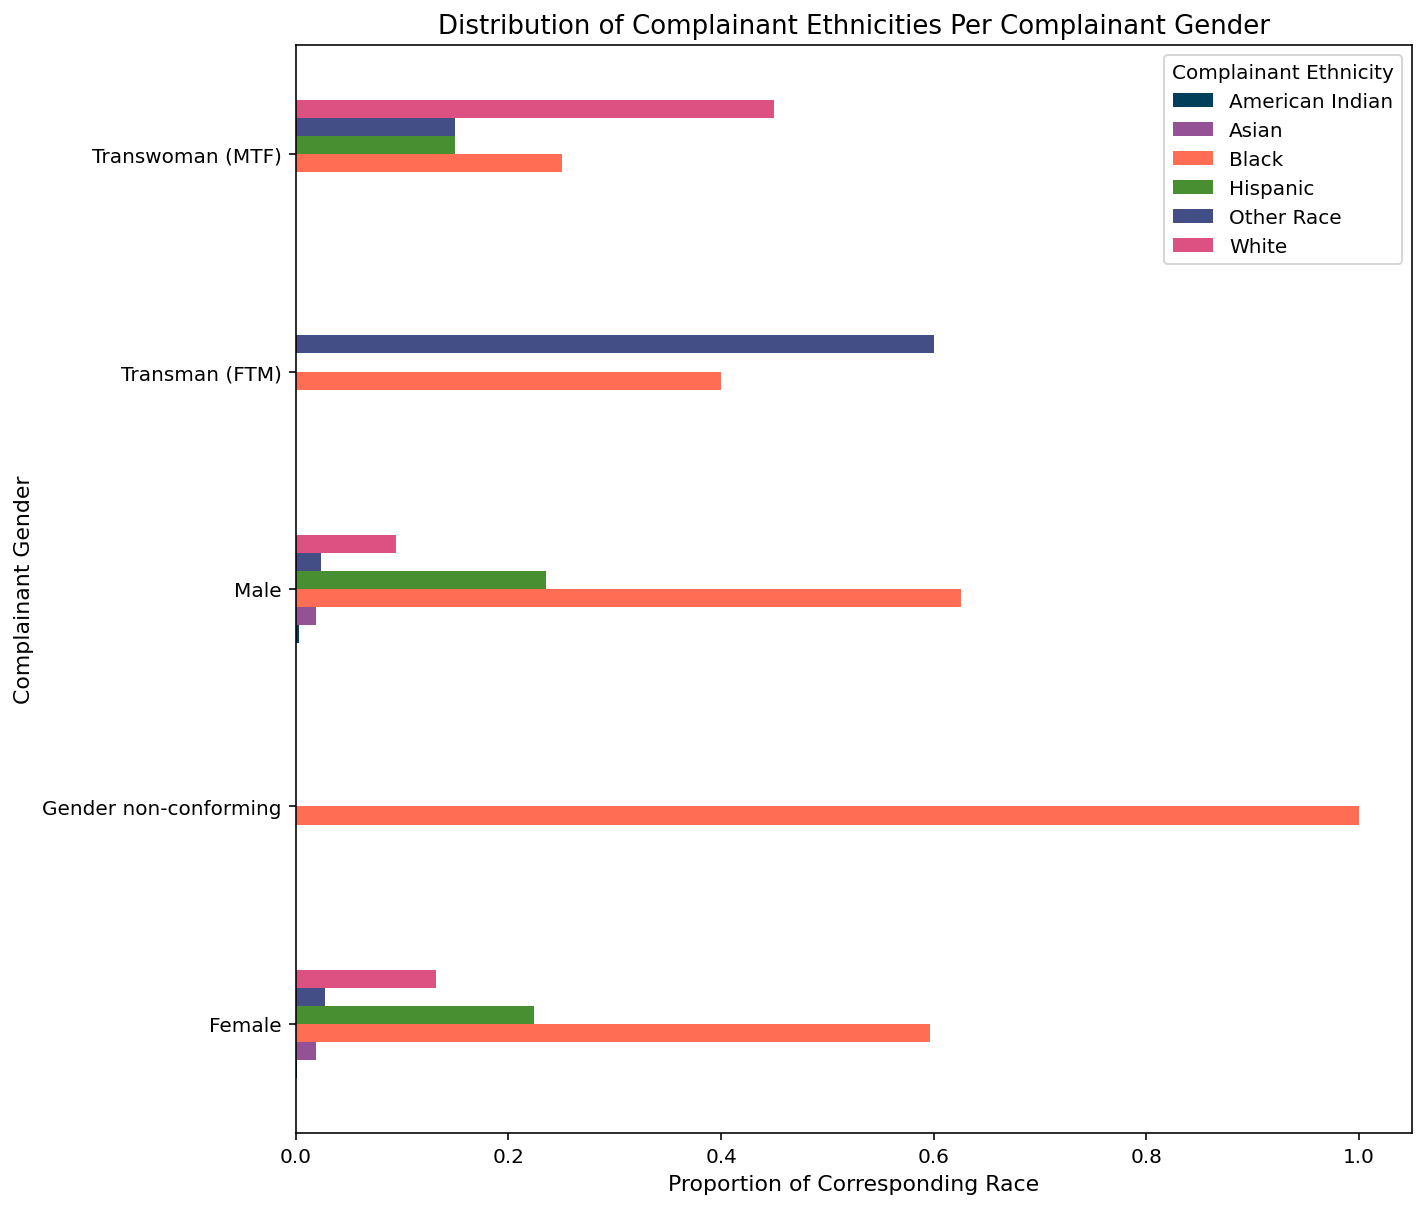

In [12]:
# Plotting the conditional distribution as a multiple bar graph
ax = race_by_gender.T.plot(kind = 'barh', figsize = (10, 10), color = ['#003f5c', '#955196', '#ff6e54', '#488f31', '#444e86', '#dd5182']);
ax.set_title('Distribution of Complainant Ethnicities Per Complainant Gender', fontsize = 13);
ax.set_xlabel('Proportion of Corresponding Race', fontsize = 11);
ax.set_ylabel('Complainant Gender', fontsize = 11);
ax.legend(title = 'Complainant Ethnicity');

In the following analysis, we wanted to determine the relation between the MOS ethnicities and FADO type. We did so by computing a pivot table and generating the conditional probabilities for each category. We then represented the data in a multiple bar graph. This shows the distribution of the MOS ethnicities based on FADO type. 
From the pivot table, we noticed that the distribution within each FADO type resembled the dstribution of MOS ethnicities fairly well. For example, in the distribution of ethnicities, 54% of MOS were white while in each FADO category, the proportion of perpetrators who were White was consistently around 54%. This could also be seen in the multiple bar graph as the conditional distributions of ethnicities for each FADO type is very similar.

In [13]:
# Finding the conditional probabilities associated with each category
raw_counts = complaints.pivot_table(index = 'mos_ethnicity', columns = 'fado_type', aggfunc = 'size').fillna(0)
mos_by_ethnicity = raw_counts / raw_counts.sum(axis = 0)
mos_by_ethnicity

fado_type,Abuse of Authority,Discourtesy,Force,Offensive Language
mos_ethnicity,,,,
American Indian,0.000838,0.001497,0.000655,0.003984
Asian,0.037502,0.031430,0.033133,0.022576
Black,0.148236,0.139619,0.149948,0.156707
Hispanic,0.275034,0.267693,0.280644,0.231076
White,0.538390,0.559761,0.535621,0.585657


In [14]:
# Finding the overall distribution of MOS ethnicity
complaints['mos_ethnicity'].value_counts(normalize = True).sort_index()

American Indian    0.000959
Asian              0.035314
Black              0.147611
Hispanic           0.274297
White              0.541819
Name: mos_ethnicity, dtype: float64

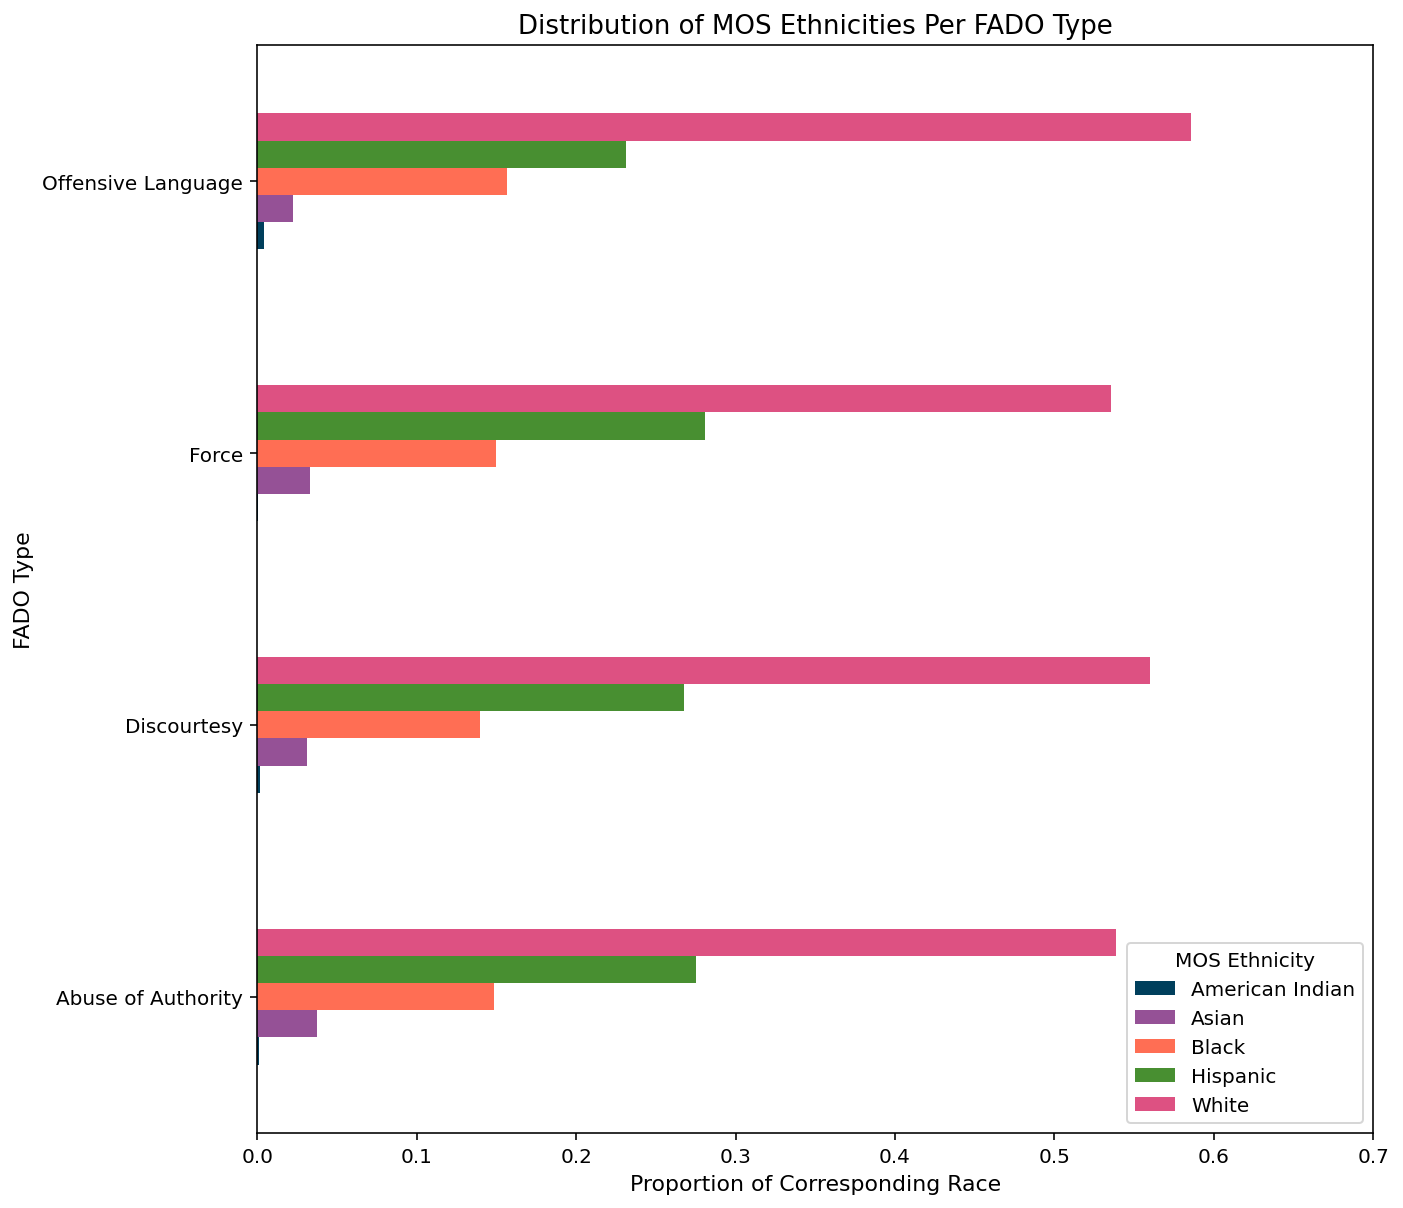

In [15]:
# Plotting the conditional distribution as a multiple bar graph
ax = mos_by_ethnicity.T.plot(kind = 'barh', figsize = (10,10), xlim = (0, 0.7), color = ['#003f5c', '#955196', '#ff6e54', '#488f31', '#dd5182'])
ax.set_title('Distribution of MOS Ethnicities Per FADO Type', fontsize = 13);
ax.set_xlabel('Proportion of Corresponding Race', fontsize = 11);
ax.set_ylabel('FADO Type', fontsize = 11);
ax.legend(title = 'MOS Ethnicity', loc = 4);

In the following analysis, we found the distribution of complainant ages conditional on their ethnicity. We chose a boxplot because it can show multiple numerical distributions on one plot conditional on a categorical variable. We noticed that the Black and Hispanic ethnicities had several outliers on the high end. The Native American ethnicity had a very small spread, which could be due to the small sample size. We noticed that the median ages of complainants were lowest for the Black and Hispanic groups, while the median age of complainants was the highest for the White group. This could suggest that the police are harsher on youths from the minority population.

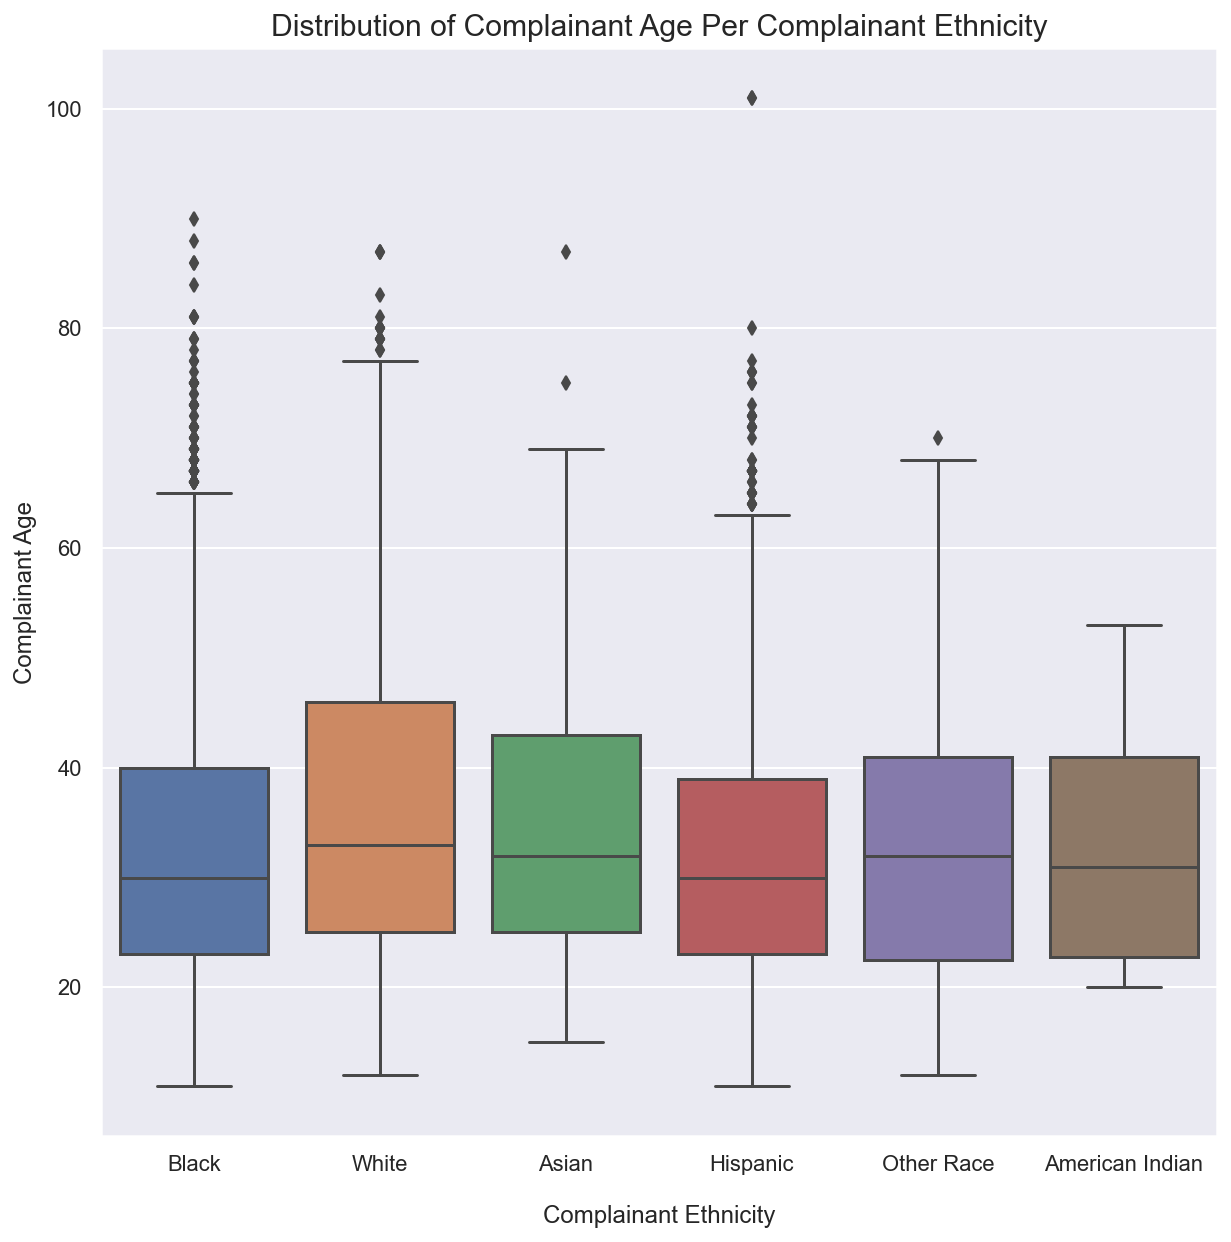

In [28]:
# Create a boxplot for each ethnicity
ax = sns.boxplot(x = complaints['complainant_ethnicity'], y = complaints['complainant_age_incident']);
sns.set(rc={'figure.figsize':(10,10)});
ax.set_xlabel('Complainant Ethnicity', fontsize = 12, labelpad = 15);
ax.set_ylabel('Complainant Age', fontsize = 12);
ax.set_title('Distribution of Complainant Age Per Complainant Ethnicity', fontsize = 15);

#### Interesting Aggregates

In this analysis, we found the number of allegations against all MOS and found their names, ethnicities, and the average age of their complainants. The top five officers were all White and had a mean complainant age of around 30 except for Joseph Tallarine, who had a mean complainant age of 19.75. This may suggest that he tends to evoke complaints from youth more.

In [17]:
# Aggregating the number of complaints for each officer and the mean age of their complainants
mos_aggregate = complaints.groupby('unique_mos_id').aggregate({'complaint_id':'count', 'complainant_age_incident': 'mean'}).sort_values(by = 'complaint_id', ascending = False)#['complaint_id'].count().sort_values(ascending = False)

# Making a df that contains the id, ethnicity, and full name for each officer
mos_info = complaints[['unique_mos_id', 'mos_ethnicity', 'mos_name']].drop_duplicates(subset = 'unique_mos_id').set_index('unique_mos_id')

# Merges the tables on the basis of the unique id, reorders columns, and renames columns
cases_for_mos = mos_aggregate.merge(mos_info, left_index = True, right_index = True)[['mos_name', 'mos_ethnicity', 'complaint_id', 'complainant_age_incident']]
cases_for_mos = cases_for_mos.rename(columns = {'mos_name': 'MOS Name', 'mos_ethnicity':'MOS Ethnicity', 'complaint_id':'Number of Allegations', 'complainant_age_incident': 'Mean Age of Complainant'}).rename_axis('MOS ID')
cases_for_mos.head()

,MOS Name,MOS Ethnicity,Number of Allegations,Mean Age of Complainant
MOS ID,,,,
18731,Daniel Sbarra,White,75,36.397059
25861,Mathew Reich,White,75,36.575342
18530,Joseph Tallarine,White,73,19.750000
19489,Gary Messina,White,73,29.451613
18589,Christophe Mccormack,White,72,32.826087


In this analysis, we found the number of incidents reported within each precinct and found the average age of the complainants and MOS for each precinct. The top five precincts had similar mean ages of the MOS and complainant. The five precincts with the highest number of incidents were all in Brooklyn or the Bronx. According to the [NYPD precinct map](https://www1.nyc.gov/site/nypd/bureaus/patrol/find-your-precinct.page), precincts 75, 73, and 67 are in Brooklyn and precincts 44 and 46 are in the Bronx.

In [18]:
# Aggregating the number of incidents in each precinct and the mean age of their complainants and MOS
incidents_by_precinct = complaints.groupby('precinct').aggregate({'complaint_id': 'count', 'mos_age_incident': 'mean', 'complainant_age_incident': 'mean'}).sort_values(by = 'complaint_id', ascending = False)

# Renaming columns and index
incidents_by_precinct = incidents_by_precinct.rename(columns = {'complaint_id': 'Number of Incidents', 'mos_age_incident': 'Mean Age of MOS', 'complainant_age_incident': 'Mean Age of Complainant'}).rename_axis('Precinct')
incidents_by_precinct.head()

,Number of Incidents,Mean Age of MOS,Mean Age of Complainant
Precinct,,,
75.0,2172,31.909300,32.290412
73.0,1163,32.300946,32.580100
44.0,1139,32.465320,32.487928
46.0,1120,32.404464,30.777547
67.0,1119,31.957998,31.562020


In this analysis, we found the average CCRB investigation time and number of incidents by year, and sorted the years according to their investigation times. We found that the years with the longest investigation times happened between 2007 to 2013, which may be related to the Great Recession. There may have been budget cuts in the CCRB, leading to fewer workers having to review more cases.

In [19]:
# Converting Timedeltas to integers and converting nanoseconds to months
investigation_months = complaints['investigation_time'].astype(int) / (8.64e+13) / 30

In [20]:
# Aggregating the number of incidents in each year and the mean investigation time
incidents_by_year = complaints.assign(months = investigation_months).groupby('year_received').aggregate({'months':'mean', 'complaint_id': 'count'}).sort_values(by = 'months', ascending = False)

# Renaming columns and index
incidents_by_year = incidents_by_year.rename(columns = {'months': 'Average Investigation Time (months)', 'complaint_id': 'Number of Incidents'}).rename_axis('Year')
incidents_by_year.head()

,Average Investigation Time (months),Number of Incidents
Year,,
2012,14.094188,1841
2011,13.314662,1896
2008,12.695667,1631
2007,12.155215,1892
2013,11.933885,2114


### Assessment of Missingness

In this section, we determined the missingness mechanisms of specific columns. The `shield_no` column is Missing by Design (MD) because it is deterministic on the `rank_now` column. Any MOS with a rank of Lieutenant or higher in the NYPD does not have a shield number, so their shield number will be missing by design.

We found a column with non-trivial missingness was `contact_reason`. We then used permutation testing to analyze the dependency of its missingness on other columns. The null hypothesis is that the data in `contact_reason` are Missing Completely at Random (MCAR). The alternative hypothesis is that the data in `contact_reason` are Missing at Random (MAR) dependent on the other column. We chose to use the `complainant_ethnicity` and `precinct` columns and conducted the permutation test below. Since the columns we chose we categorical, we used the total variation distance (TVD) as our test statistic. We chose a significance level of 0.05.

In [21]:
def perm4missing(col, N):
    """
    perm4missing takes in a column col, and a number N and returns the
    p-value of the test (using N simulations) that determines if
    `contact_reason` is MAR dependent on col.
    """
    def make_pivot(nulls):
        """
        Generates a pivot table where the index is True/False depending on whether the 
        contact_reason is null. Finds the conditional distribution.
        """
        pivot = columns_of_interest.assign(contact_is_null = nulls)\
            .pivot_table(index = 'contact_is_null', columns = col, aggfunc = 'size')\
            .apply(lambda x: x / x.sum(), axis = 1).fillna(0)
        return pivot

    def get_tvd(pivot):
        """
        Calculates the total variation distance (TVD) of the conditional distribution of col
        on contact_reason.
        """
        return pivot.diff(axis = 0).abs().iloc[-1].sum() / 2

    # Narrow the dataframe to columns of interest for efficiency
    columns_of_interest = complaints[['contact_reason', col]]

    # Make boolean array for null contact reasons and find the observed test statistic
    contact_reason_nulls = columns_of_interest['contact_reason'].isnull()
    observed_pivot = make_pivot(contact_reason_nulls)
    observed_tvd = get_tvd(observed_pivot)

    # Array to store simulated/empirical test statistics
    tvds = []
    
    for _ in range(N):
        # Permute the contact reason nulls
        is_null = contact_reason_nulls.sample(frac = 1, replace = False).reset_index(drop = True)

        # Calculate the empirical tvd and append to the empirical tvds list
        sim_pivot = make_pivot(is_null)
        sim_tvd = get_tvd(sim_pivot)
        tvds.append(sim_tvd)

    # Find the proportion of empirical tvds that were at least as extreme as the observed tvd
    p_val = np.count_nonzero(tvds >= observed_tvd) / N
    
    return p_val

In [22]:
perm4missing('complainant_ethnicity', 1000)

0.241

In [23]:
perm4missing('precinct', 1000)

0.0

Conclusions from Missingness Permutation tests:
* Complainant Ethnicity: At a 5% significance level, we fail to reject the null hypothesis that `contact_reason` is not dependent on `complainant_ethnicity`. In other words, there is insufficient evidence to support the claim that `contact_reason` is MAR dependent on `complainant_ethnicity`.
* Precinct: At a 5% significance level, we reject the claim that `contact_reason` is not dependent on `precinct`. In other words, there is sufficient evidence to support the claim that `contact_reason` is MAR dependent on `precinct`. This could mean that certain precincts tend to lose complaint files, leading to missing values in the `contact_reason` column.

After several permutation tests for dependence of `contact_reason` on precinct, we noticed that the p-value was always 0.0. This led us to examine the proportion of null values in the `contact_reason` column. 

In [24]:
complaints['contact_reason'].isna().mean()

0.005965585466754602

Only around 0.5% of the `contact_reason` column is null. Due to the large disparity between the sizes of the null and non-null contact_reasons, these results are unreliable. Therefore, although the significance test showed that there was sufficient evidence to reject the null hypothesis, we cannot be sure that the column is MAR dependent on `precinct`.

### Hypothesis Test / Permutation Test

#### Question: 
Do complaints made by Black individuals have a varying degree of success than complaints made by non-Black individuals?

To answer this question, we decided to run a permutation (A/B) Test because there are two distinct populations: Black and non-Black complainants. The null hypothesis is that the populations are from the same distribution, so they have the same degree of success. The alternative hypothesis is that the populations have varying degrees of success, and originate from different distributions. Since the columns we chose we categorical, we used the total variation distance (TVD) as our test statistic. We chose a significance level of 0.01.

In [26]:
def make_pivot(is_black):
    """
    Generates a pivot table where the index is True/False depending on whether the 
    complainant is black. Finds the conditional distribution.
    """
    pivot = encoded_columns.assign(shuffled = is_black)\
        .pivot_table(index = 'shuffled', columns = 'is_successful', aggfunc = 'size')\
        .apply(lambda x: x / x.sum(), axis = 1)
    return pivot

def get_tvd(pivot):
    """
    Calculates the total variation distance (TVD) of the conditional distribution of the success
    on whether the complainant is black.
    """
    return pivot.diff(axis = 0).abs().iloc[-1].sum() / 2

# Narrow the dataframe to columns of interest for efficiency
columns_of_interest = complaints[['complainant_ethnicity', 'board_disposition']]

# Dropped NaN ethnicity because we are unsure whether they belong to the Black or non-Black category
columns_of_interest = columns_of_interest.dropna(subset = ['complainant_ethnicity']).reset_index(drop = True)

# Boolean arrays for whether a complainant is black or a case was successful for the complainant (substantiated)
is_black_comp = columns_of_interest['complainant_ethnicity'] == 'Black'
is_successful_comp = columns_of_interest['board_disposition'].apply(lambda x: True if 'Substantiated' in x else False)

# Added the Boolean arrays to the dataframe and dropped irrelevant columns
encoded_columns = columns_of_interest.assign(is_black = is_black_comp, is_successful = is_successful_comp)
encoded_columns.drop(columns = ['complainant_ethnicity', 'board_disposition'], inplace = True)

# Create the pivot table and calculated the observed test statistic for the data
observed_pivot = make_pivot(encoded_columns['is_black'])
observed_tvd = get_tvd(observed_pivot)

# Array to store simulated/empirical test statistics
tvds = []

for _ in range(1000):
    # Permute the is_black column
    is_black = encoded_columns['is_black'].sample(frac = 1, replace = False).reset_index(drop = True)

    # Calculate the empirical tvd and append to the empirical tvds list
    sim_pivot = make_pivot(is_black)
    sim_tvd = get_tvd(sim_pivot)
    tvds.append(sim_tvd)

# Find the proportion of empirical tvds that were at least as extreme as the observed tvd
p_val = np.count_nonzero(tvds >= observed_tvd) / 1000
p_val

0.001

Conclusion:
At a 1% significance level, we reject the claim that the distribution of successful complaints for Black and non-Black individuals is the same. In other words, there is sufficient evidence to support the claim that the distribution of complaints originate from distinct distributions. This could mean that the success of a case may be impacted by, or associated with, whether or not the complainant was Black.

Once again, although the permutation test suggested to reject the null hypothesis, we must be skeptical of this conclusion because the distributions were not even. More specifically, there were 25,057 unsuccessful claims and only 8,301 successful claims. There were 17,114 Black complainants and 10,480 non-Black complainants. This makes it difficult to generalize the results because the distributions are skewed towards Black complainants and unsuccessful claims.